In [1]:
import os
import sys
import json
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from transformers import BertModel, BertTokenizer

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

I0422 04:25:44.083183 140554695829312 file_utils.py:39] PyTorch version 1.1.0 available.


'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')

In [3]:
from fgc_support_retri.ser_extractor import *
from fgc_support_retri.utils import *
from fgc_support_retri import config
from fgc_support_retri.evaluation.fgc_eval import *
from fgc_support_retri.evaluation.eval import eval_sp_fgc, eval_fgc_atype

# Extract se

In [4]:
model_name = "20200413_ematch+sf" 

In [5]:
model_folder = config.TRAINED_MODELS / model_name

In [6]:
model_folder

PosixPath('/work/fgc_support_retri/results/trainedmodels/20200413_ematch+sf')

In [7]:
extractor = EntityMatch_extractor(model_folder, 'sf')

I0422 04:26:56.152468 140554695829312 tokenization_utils.py:375] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt from cache at /root/.cache/torch/transformers/8a0c070123c1f794c42a29c6904beb7c1b8715741e235bee04aca2c7636fc83f.9b42061518a39ca00b8b52059fd2bede8daa613f8a8671500e518a8c29de8c00
I0422 04:26:57.052012 140554695829312 configuration_utils.py:152] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json from cache at /root/.cache/torch/transformers/8a3b1cfe5da58286e12a0f5d7d182b8d6eca88c08e26c332ee3817548cf7e60a.3767c74c8ed285531d04153fe84a0791672aff52f7249b27df341dbce09b8305
I0422 04:26:57.055051 140554695829312 configuration_utils.py:169] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_r

In [80]:
data = json_load(config.FGC_TEST)

In [81]:
get_answer_sp(data, force=True)

100%|██████████| 193/193 [00:00<00:00, 26214.40it/s]


In [82]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(data):
    for q in d['QUESTIONS']:
        if not q['SHINT_']:
            continue
        sp_preds = []
        sp_scores = []
        sp_preds, _, sp_scores = extractor.predict(q, d)
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 193/193 [02:09<00:00,  1.49it/s]


In [83]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(data, threshold=0.5)

100%|██████████| 193/193 [00:00<00:00, 63222.48it/s]


In [84]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.084, 'sp_prec': 0.497, 'sp_recall': 0.764, 'sp_f1': 0.554}


In [85]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.063, 'sp_prec': 0.341, 'sp_recall': 0.804, 'sp_f1': 0.435}


In [86]:
len(all_items)

190

In [77]:
import copy
try_data = copy.deepcopy(data)

for d in tqdm(try_data):
    for q in d['QUESTIONS']:
        if not q['SHINT_']:
            continue
        sp_preds = []
        sp_scores = []
        orig_sp = q['sp']
        orig_scores = q['sp_scores']
        
        neighbor_pairs = get_target_s(orig_sp, len(d['SENTS']), window=1, bidirectional=False)
        sp2_set = set([t for _, t in neighbor_pairs])
        sp_preds = list(set(orig_sp).union(sp2_set))
        sp_preds.sort()
        for i in sp_preds:
            orig_scores[i] = 1.0
        sp_scores = orig_scores
        assert sp_preds != []
        assert sp_scores != []
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 193/193 [00:00<00:00, 97050.79it/s]


In [78]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(try_data, threshold=0.5)

100%|██████████| 193/193 [00:00<00:00, 112932.57it/s]


In [79]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.047, 'sp_prec': 0.416, 'sp_recall': 0.799, 'sp_f1': 0.507}
{'sp_em': 0.021, 'sp_prec': 0.281, 'sp_recall': 0.829, 'sp_f1': 0.383}


# Write analysis

In [15]:
write_analysis(model_name +'.txt', data, 'all')

# Draw intervals

In [15]:
def get_interval_span():
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    return intervals

In [16]:
def get_interval(score):
    # get interval span
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    
    # get interv_i
    for interv_i, interv in enumerate(intervals):
        if interv[0] <= score < interv[1]:
            return interv_i

In [17]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [18]:
intervals = get_interval_span()

In [21]:
split_data = split_data_by_atype(data)

In [22]:
split_data.keys()

dict_keys(['Person', 'Date-Duration', 'Location', 'Organization', 'Num-Measure', 'YesNo', 'Kinship', 'Event', 'Object', 'Misc'])

In [23]:
defined_data = []
undefined_data = []
not_yesno_data = []
for atype in ATYPE_LIST:
    if atype in atype2etype:
        defined_data += split_data[atype]
    else:
        undefined_data += split_data[atype]
    if atype != 'YesNo':
        not_yesno_data += split_data[atype]

In [24]:
data_to_eval = data

In [25]:
def eval_data(data):
    gold_se = []
    gold_answer_se = []
    predict_se = []
    for d in tqdm(data):
        for q in d['QUESTIONS']:
            if not q['SHINT_']:
                continue
            gold_se.append(q['SHINT_'])
            gold_answer_se.append(q['answer_sp'])
            predict_se.append(q['sp'])
    print("{} data".format(len(predict_se)))
    print("all se")
    print(eval_sp_fgc(gold_se, predict_se))
    print("anser_se")
    print(eval_sp_fgc(gold_answer_se, predict_se))

In [26]:
eval_data(data_to_eval)

100%|██████████| 247/247 [00:00<00:00, 157829.54it/s]

239 data
all se
{'sp_em': 0.079, 'sp_prec': 0.437, 'sp_recall': 0.768, 'sp_f1': 0.506}
{'sp_em': 0.079, 'sp_prec': 0.437, 'sp_recall': 0.768, 'sp_f1': 0.506}
anser_se
{'sp_em': 0.042, 'sp_prec': 0.277, 'sp_recall': 0.759, 'sp_f1': 0.365}
{'sp_em': 0.042, 'sp_prec': 0.277, 'sp_recall': 0.759, 'sp_f1': 0.365}


In [27]:
interv_scores_p = [0] * 10
interv_scores_n = [0] * 10
interv_scores_answer = [0] * 10
interv_scores_not_answer = [0] * 10

low_score_data = set()
miss_answer_se_set = set()

for d_i, document in enumerate(data_to_eval):
    for q in document['QUESTIONS']:
        if not q['SHINT_']:
            continue
        for sent_i, sp_score in enumerate(q['sp_scores']):
            if sent_i in q['SHINT_']:
                interv_scores_p[get_interval(sp_score)] += 1
                if sent_i in q['answer_sp']:
                    interv_scores_answer[get_interval(sp_score)] += 1
                    if (get_interval(sp_score) == 0 or get_interval(sp_score) == 1):
                        low_score_data.add(d_i)
                    if sent_i not in q['sp']:
                        miss_answer_se_set.add(d_i)
                else:
                    interv_scores_not_answer[get_interval(sp_score)] += 1
            else:
                interv_scores_n[get_interval(sp_score)] += 1

In [28]:
interv_scores_p

[129, 9, 10, 8, 6, 10, 7, 27, 36, 305]

I0420 10:49:56.353631 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0420 10:49:56.357963 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'all SE')

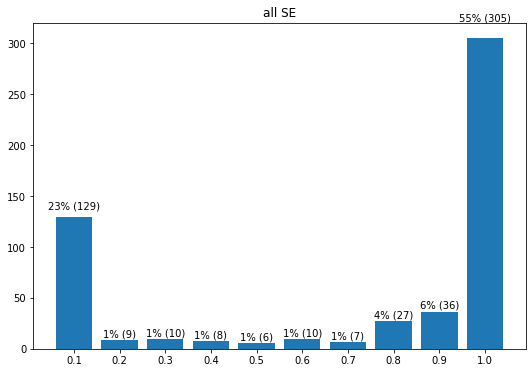

In [29]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores_p)
createLabels(A)
plt.title('all SE')

I0420 10:49:56.738025 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0420 10:49:56.740947 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not SE')

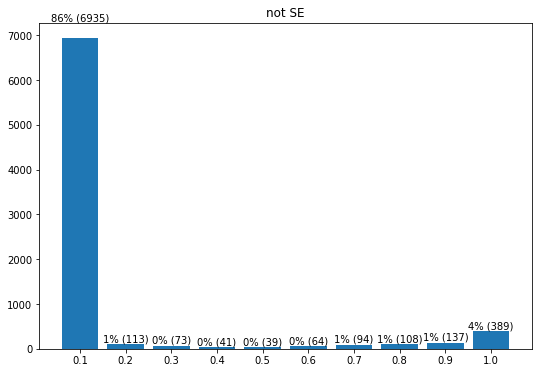

In [30]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_n)
createLabels(B)
plt.title('not SE')

I0420 10:49:57.662567 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0420 10:49:57.665886 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'answer SE')

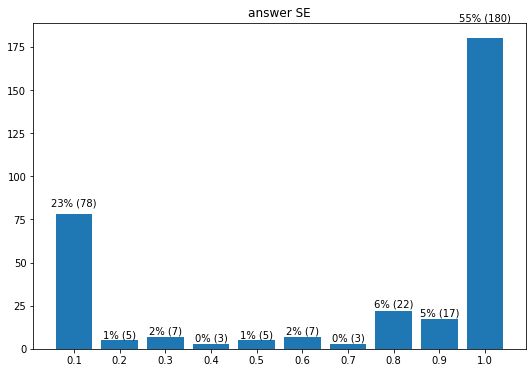

In [31]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_answer)
createLabels(B)
plt.title('answer SE')

I0420 10:49:58.583252 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0420 10:49:58.585351 140305641580352 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'SE but not answer SE')

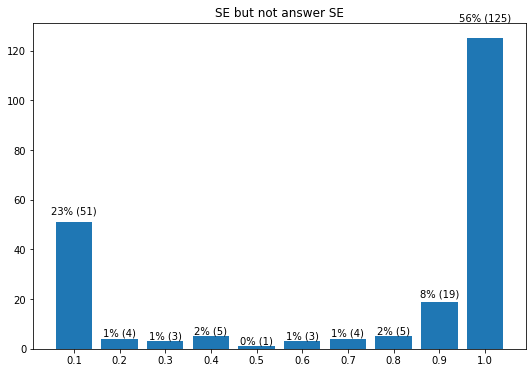

In [32]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_not_answer)
createLabels(B)
plt.title('SE but not answer SE')

In [33]:
low_score_eval_data = [data_to_eval[i] for i in low_score_data]

In [34]:
len(data_to_eval)

247

In [35]:
len(low_score_eval_data)

60

In [36]:
qids = [q['QID'] for d in low_score_eval_data for q in d['QUESTIONS']]    

In [37]:
stage1_qids = ['D127Q02',
 'D127Q04',
 'D127Q07',
 'D001Q07',
 'D181Q02',
 'D181Q03',
 'D001Q10',
 'D181Q05',
 'D007Q03',
 'D211Q03',
 'D211Q04',
 'D013Q01',
 'D211Q05',
 'D241Q04',
 'D241Q05',
 'D241Q06',
 'D241Q09',
 'D247Q02',
 'D031Q01',
 'D031Q02',
 'D247Q08',
 'D247Q09',
 'D253Q05',
 'D253Q07',
 'D037Q18',
 'D037Q19',
 'D037Q20',
 'D259Q06',
 'D049Q02',
 'D049Q03',
 'D259Q07',
 'D049Q05',
 'D259Q11',
 'D049Q09',
 'D271Q04',
 'D061Q04',
 'D283Q02',
 'D283Q04',
 'D073Q05',
 'D073Q07',
 'D289Q02',
 'D073Q09',
 'D289Q04',
 'D289Q08',
 'D079Q07',
 'D295Q02',
 'D085Q04',
 'D085Q06',
 'D295Q06',
 'D295Q07',
 'D295Q08',
 'D301Q04',
 'D307Q01',
 'D097Q03',
 'D307Q03',
 'D097Q06',
 'D307Q07',
 'D097Q08',
 'D097Q09',
 'D325Q04',
 'D103Q08',
 'D325Q05',
 'D115Q03',
 'D115Q04',
 'D115Q05',
 'D115Q07']

In [40]:
for qid in qids:
    if qid not in stage1_qids:
        print(qid)

In [41]:
for qid in stage1_qids:
    if qid not in qids:
        print(qid)

D127Q04
D181Q03
D241Q04
D247Q02
D271Q04
D307Q01


In [38]:
low_score_split_data = split_data_by_atype(low_score_eval_data)

In [39]:
for k in low_score_split_data.keys():
    print(k)
    print(len(low_score_split_data[k]))

Person
9
Date-Duration
6
Location
6
Organization
4
Num-Measure
4
YesNo
0
Kinship
0
Event
2
Object
14
Misc
0


In [38]:
write_analysis(model_name+'_low_score.txt', low_score_eval_data, 'only')

# Try extract model

In [ ]:
items = [item for item in extractor.dataset_reader.get_items_in_q(q,d)]

In [ ]:
len(items)